# Conjugate gradient method
### Carl Fredrik Berg, NTNU, 2023

## Introduction
The conjugate gradient method is probably the most popular method for solving large systems of linear equations. We will consider a system of linear equations with $n$ variables and $n$ equations.
$$
\begin{align}
a_{11} x_1 + a_{12} x_2 + \cdots +a_{1n}x_n &= b_1 \\
a_{21} x_1 + a_{22} x_2 + \cdots +a_{2n}x_n &= b_2 \\
\vdots \\
a_{n1} x_1 + a_{n2} x_2 + \cdots +a_{nn}x_n &= b_n
\end{align}
$$

This system of linear equations can be rewritten on matrix form as $\bf{A}\bf{x}=\bf{b}$, where $\mathbf{A} \in \mathbb{R}^{n \times n}$, $\mathbf{x} \in \mathbb{R}^n$ and $\mathbf{b} \in \mathbb{R}^n$.

In this lecture we will consider systems where $\bf{A}$ is a symmetric, positive definite square matrix (see definitions below). Such a system will be solved by the conjugate gradient method, or CG-method for short. We will consider it as an iterative algorithm, which is the usually way of implementing it. It is well suited for large sparse matrices, as we will encounter later in the course when we will solve partial differential equations on grid models.

The method was introduced by Hestenes and Stiefel in 1952:

Hestenes, Magnus R., and Eduard Stiefel. "Methods of conjugate gradients for solving." Journal of research of the National Bureau of Standards 49.6 (1952): 409.

### Matrix definitions

In this lecture we will always assume that $\mathbf{A}$ is a square matrix, thus $\mathbf{A} \in \mathbb{R}^{n\times n}$.

<b>Definition:</b> A matrix $\mathbf{A}$ is <i>symmetric</i> when $\mathbf{A}^\text{T} = \mathbf{A}$.

<b>Definition:</b> A matrix $\mathbf{A}$ is <i>positive definite</i> when $\mathbf{x}^\text{T}\mathbf{A}\mathbf{x} > 0 \, \forall \, \mathbf{x}$.

<b>Lemma:</b> A matrix $\mathbf{A}$ is <i>positive definite</i> if and only if all its eigenvalues are positive.

### Quadratic form

A quadratic form is a polynomial of degree two, e.g., $3x^2+4xy+2y^2$. 

Any $n \times n$ matrix $\mathbf{A}$ defines a quadratic from, usually denote $q_\mathbf{A}$, as $$q_\mathbf{A} = \mathbf{x}^\text{T} \mathbf{A} \mathbf{x}$$

As an example, the matrix
$$\mathbf{B} = \begin{bmatrix}3&1\\3&2\end{bmatrix}$$
will give the quadratic form $q_\mathbf{B} = 3x^2+4xy+2y^2$. Note that $$\mathbf{C} = \begin{bmatrix}3&4\\0&2\end{bmatrix}$$ will give the same quadratic from $q_\mathbf{C} = 3x^2+4xy+2y^2 = q_\mathbf{B}$. There is, however, a <i>unique symmetric</i> matrix representing the quadratic form:
$$\mathbf{A} = \begin{bmatrix}3&2\\2&2\end{bmatrix}$$
Whenever we talk of the matrix representation $\mathbf{A}$ of a quadratic from $q_\mathbf{A}$, we will always mean the unique symmetric matrix. 

From the positive definite symmetric matrix $\mathbf{A}$ and vector $\mathbf{b}$ we can define a quadratic form as $$f(\mathbf{x}) =\frac{1}{2}\mathbf{x}^\text{T} \mathbf{A} \mathbf{x} - \mathbf{b}^\text{T} \mathbf{x} + c$$
Note that the value $c$ is only shifting the quadratic form.

If $\mathbf{A}$ is positive definite then $f(\mathbf{x})$ looks like a paraboloid bowl. See code below for an example plot.

#### Check if matrix is positive definite

To check if a matrix is positive definite, we can if the eigenvalues are positive. In the code below we will check if the matrix 
$$\mathbf{A} = \begin{bmatrix}3&2\\2&2\end{bmatrix}$$
is positive definite by checking all its eigenvalues.

In [1]:
import numpy as np
A=np.array([[3, 2],[2,2]])
np.linalg.eigvals(A)

array([4.56155281, 0.43844719])

Below we have a code to plot the parabolic bowl for a given matrix.

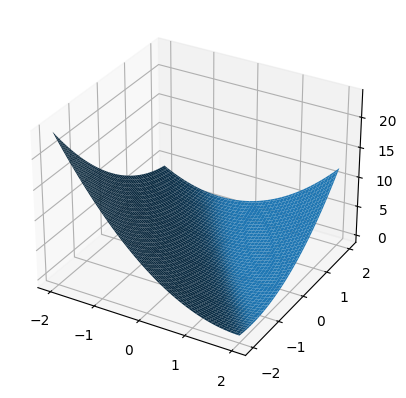

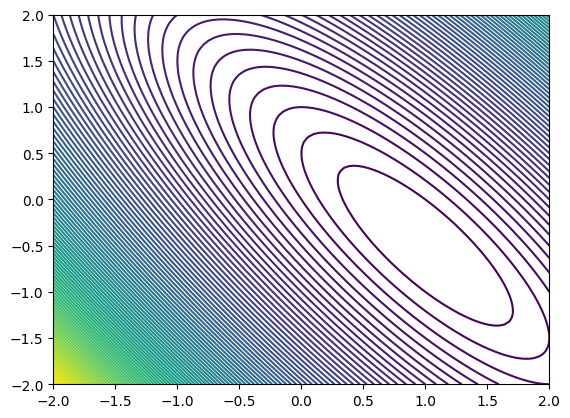

In [2]:
#import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#A=np.array([[1, 0],[0,1]])
#b=np.array([0,0])
A=np.array([[3, 2],[2,2]])
b=np.array([2,1])
c=0

def f(x,y,A,b,c):
    xv=np.array([x,y])
    return 0.5*np.dot(np.dot(xv.T,A),xv)-np.dot(b.T,xv)+c

x = np.linspace(-2, 2, 100)
y = np.copy(x)

xv, yv = np.meshgrid(x, y)

xr=np.ravel(xv)
yr=np.ravel(yv)

z=[]
for ii in range(0,len(xr)):
    z.append(f(xr[ii],yr[ii],A,b,c))
zr=np.asarray(z)
zv=zr.reshape(xv.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xv,yv,zv)
plt.show()

fig = plt.figure()
plt.contour(xv,yv,zv,100)
plt.show()

### Quadratic form optimization

We now want to optimize the function $f$ by finding its extremum, i.e., finding the extremum of the quadratic form given by $f$. When $\mathbf{A}$ is positive definite, the extremum of $f$ will be its minimum, so we will talk about finding the minimum of $f$ in the following.

Thus we want to find the vector $\mathbf{x}$ where $\nabla f(\mathbf{x}) = 0$. Remember that $$\nabla f(\mathbf{x}) = \begin{bmatrix} \frac{\partial f}{\partial x_1} (\mathbf{x}) \\ \vdots \\ \frac{\partial f}{\partial x_n} (\mathbf{x})\end{bmatrix}$$

It can be shown that the gradient of $f(\mathbf{x})$ is $$ \nabla f(\mathbf{x}) = \frac{1}{2}\mathbf{A}^\text{T} \mathbf{x} + \frac{1}{2}\mathbf{A} \mathbf{x} - \mathbf{b} $$
The derivation of the above equation is not straight forward, but you can just write out the quadratic form as a polynomial of degree two to see that this holds.

Since $\mathbf{A}$ is symmetric we have that $\mathbf{A}^\text{T} = \mathbf{A}$, thus
$$\nabla f(\mathbf{x}) = \mathbf{A} \mathbf{x} - \mathbf{b}$$

Note that if $\mathbf{A}$ is not symmetric we get $\frac{1}{2} \left( \mathbf{A}^\text{T} + \mathbf{A} \right)\mathbf{x} = \mathbf{b}$, where $\left( \mathbf{A}^\text{T} + \mathbf{A} \right)$ is symmetric.

So, to find the minimum of $f(\mathbf{x})$, we find where $\nabla f = 0$, thus we solve a system of linear equations $$\mathbf{A} \mathbf{x} = \mathbf{b}$$
by minimizing the quadratic from $$f(\mathbf{x}) =\frac{1}{2}\mathbf{x}^\text{T} \mathbf{A} \mathbf{x} - \mathbf{b}^\text{T} \mathbf{x}$$

This is what we want to do with the gradient decent method. But first, let us have a look at the steepest decent method.

### Steepest descent

In the steepest descent algorithm we progress from an arbitrary point $\mathbf{x}_0$ towards the minimal point of $f(\mathbf{x})$ by moving in the direction of the steepest descent. The direction of the steepest descent in a point is given by the gradient $\nabla f(\mathbf{x})$. Since we will use this steepest descent direction repeatedly, we will define $\mathbf{r} = -\nabla f(\mathbf{x})$ as the direction of steepest descent. Note that $\mathbf{r}$ is not necessarily of length 1.

Steepest descent is an iterative optimization method in the form
$$
\mathbf{x}_{i+1} = \mathbf{x}_i-\alpha_i\nabla f(\mathbf{x}_i) = \mathbf{x}_i + \alpha_i \mathbf{r}_i
$$
where we have used our definition of steepest descent direction $\mathbf{r}_i = -\nabla f(\mathbf{x}_i)$. Thus $\mathbf{r}_i$ is the direction of steepest descent in point $\mathbf{x}_i$.

If we consider $\mathbf{x}_{i+1}$ as a function of $\alpha_i$, then the step length $\alpha_i$ should minimize $\Phi(\alpha_i) = f(\mathbf{x}_{i+1}(\alpha_i))$:
$$
\frac{d f(\mathbf{x}_{i+1})}{d \alpha_i} = \left[ \nabla f(\mathbf{x}_{i+1}) \right]^\text{T} \frac{d \mathbf{x}_{i+1}}{d \alpha_i} = -\left[ \nabla f(\mathbf{x}_{i+1}) \right]^\text{T} \nabla f(\mathbf{x}_i) = 
$$
$$-\mathbf{r}_{i+1}^\text{T} \mathbf{r}_{i} = 0 $$

Thus, in the steepest descent method the current $\mathbf{r}_{i+1}$ and preceding $\mathbf{r}_{i}$ search directions are orthogonal, i.e., $\mathbf{r}_{i+1}^\text{T} \mathbf{r}_{i} = 0 $. Note that this holds for an arbitrary $f(\mathbf{x})$).

Remember that $\mathbf{r}_i = -\nabla f(\mathbf{x}_i) = \mathbf{b} - \mathbf{A} \mathbf{x}_i$. We can then find the value of $\alpha_i$ that minimize $\Phi(\alpha_i) = f(\mathbf{x}_{i+1}(\alpha_i))$:
$$\begin{align}
\frac{d f(\mathbf{x}_{i+1})}{d \alpha_i} &= 0 \\
\mathbf{r}_{i+1}^\text{T} \mathbf{r}_{i} &= 0 \\
\left[ \mathbf{b} - \mathbf{A} \mathbf{x}_{i+1} \right]^\text{T} \mathbf{r}_i &= 0 \\
\left[ \mathbf{b} - \mathbf{A} (\mathbf{x}_i+\alpha_i\mathbf{r}_i) \right]^\text{T} \mathbf{r}_i &= 0\\
\left[\mathbf{b} - \mathbf{A}\mathbf{x}_i\right]^\text{T} \mathbf{r}_i - \alpha_i \left[ \mathbf{A}\mathbf{r}_i \right]^\text{T} \mathbf{r}_i &= 0 \\
\mathbf{r}_i^\text{T} \mathbf{r}_i - \alpha_i \mathbf{r}_i^\text{T}\mathbf{A}  \mathbf{r}_i &= 0 
\end{align}$$
In the last line we used that $\mathbf{A}$ is symmetric, thus $\mathbf{A}^\text{T} = \mathbf{A}$. We thus get 
$$\alpha_i = \frac{\mathbf{r}_i^\text{T} \mathbf{r}_i}{\mathbf{r}_i^\text{T} \mathbf{A} \mathbf{r}_i}$$

Following this procedure we will move iteratively towards the minimal value of $\nabla f(\mathbf{x}) = \mathbf{A} \mathbf{x} - \mathbf{b}$, thus finding a solution to the set of linear equations $\mathbf{A} \mathbf{x} = \mathbf{b}$.

In [3]:
#import numpy as np
from math import *

def steepdesc(A,b,x,maxiter,eps) :
  success = False
  #Iterate over estimates of x
  for i in range(0,maxiter):  
    #Find search direction:
    r = b-np.dot(A,x)
    res = sqrt(np.dot(r,r)) 
    fval = 0.5*np.dot(x,np.dot(A,x))-np.dot(b,x)
    print("Iteration: ",i,"f value: ",fval,"Error: ",res,"Position: ",x,"Direction: ",r)
    if(res < eps):
      success = True
      break

    #Compute alfa
    alpha = np.dot(r,r)/np.dot(r,np.dot(A,r))

    #update solution
    x = x+alpha*r
  return [x,success]

eps=1.0e-08
maxiter = 100
x0=np.array([0,0])

x,success = steepdesc(A,b,x0,maxiter,eps)
print(x,success)

invA=np.linalg.inv(A)
print(np.dot(invA,b))

Iteration:  0 f value:  0.0 Error:  2.23606797749979 Position:  [0 0] Direction:  [2 1]
Iteration:  1 f value:  -0.5681818181818181 Error:  0.4065578140908708 Position:  [0.45454545 0.22727273] Direction:  [ 0.18181818 -0.36363636]
Iteration:  2 f value:  -0.7059228650137741 Error:  0.5420770854544941 Position:  [ 0.75757576 -0.37878788] Direction:  [0.48484848 0.24242424]
Iteration:  3 f value:  -0.7393146339427331 Error:  0.09855947008263526 Position:  [ 0.8677686  -0.32369146] Direction:  [ 0.04407713 -0.08815427]
Iteration:  4 f value:  -0.7474096082285413 Error:  0.13141262677684612 Position:  [ 0.94123049 -0.47061524] Direction:  [0.11753903 0.05876951]
Iteration:  5 f value:  -0.7493720262372222 Error:  0.023893204868516926 Position:  [ 0.9679439  -0.45725854] Direction:  [ 0.01068537 -0.02137073]
Iteration:  6 f value:  -0.7498477639362965 Error:  0.0318576064913561 Position:  [ 0.98575285 -0.49287642] Direction:  [0.02849431 0.01424715]
Iteration:  7 f value:  -0.7499630942875

As might be obvious from trying out the code above for different linear systems $\mathbf{A} \mathbf{x} = \mathbf{b}$ and different initial positions $\mathbf{x}_0$ is that the method is both unstable and have slow convergence. The reason is that the response surface of the quadratic form $f(\mathbf{x}) =\frac{1}{2}\mathbf{x}^\text{T} \mathbf{A} \mathbf{x} - \mathbf{b}^\text{T} \mathbf{x}$ is so elliptic. For the simple case of a $2\times 2$ matrix $\mathbf{A} = I$ the contour lines of the quadratic form will be circular, and the steepest decent will work fine. However, this is a trivial example that does not really need a numerical method to be solved. For more complex $\mathbf{A}$ the contour lines will be elliptic, and the gradient will not point towards the minimum of the quadratic form. In such cases, the steepest decent will use a high number of iterations to reach the minimum.

![alt text](steepest_descent_quadratic.png "Title")

With the conjugate gradient method we will transform the space, using the eigenvectors, so that we end up in a space where the contour lines are spherical, and thus where the steepest decent will work smoothly.

### Conjugate gradient method

In normal Euclidean space $\mathbb{R}^n$, two vectors $\mathbf{x}$ and $\mathbf{y}$ are orthogonal when $\mathbf{x}^\text{T} \mathbf{y} = 0$. Note that $\mathbf{x}^\text{T} \mathbf{y}$ is also called the inner product, and often denoted $\left<\mathbf{x},\mathbf{y} \right>$.

For the conjugate gradient method we want to work in a space that is transformed by the matrix $\mathbf{A}$. To talk about orthogonality in the transformed space, we need the following definition:

<b>Definition:</b> Two vectors $\mathbf{x}$ and $\mathbf{y}$ are called $\mathbf{A}$-orthogonal (or conjugate) when $\mathbf{x}^\text{T} \mathbf{A} \mathbf{y} = 0$.

It is also common to denote $\mathbf{x}^\text{T} \mathbf{A} \mathbf{y}$ as $\left<\mathbf{x},\mathbf{y} \right>_\mathbf{A}$

In some sense, the two vectors are then orthogonal in the space stretched by $\mathbf{A}$. Thus, if we transform the space given by $\mathbf{A}$ back to the "original" space (where all the contours are spherical), then the two vectors will be orthogonal in the usual sense.

As with the steepest decent, we want to move the current location $\mathbf{x}_i$ iteratively, but this time in a direction $\mathbf{d}_i$, where the different $\mathbf{d}_i$ vectors are $\mathbf{A}$-orthogonal. We thus want to iterate the position as
$$\mathbf{x}_{i+1} = \mathbf{x}_i + \alpha_i \mathbf{d}_i$$
where $\mathbf{d}_i$ is the direction and $\alpha_i$ is the step length.

The search direction is updated iteratively as:
$$\mathbf{d}_{i+1} = \mathbf{r}_{i+1} + \beta_{i+1} \mathbf{d}_i$$
To find the $\beta$ values we will use the Gram-Schmidt process.

#### Error and residual
The <i>error</i> $\mathbf{e}_i = \mathbf{x}_i - \mathbf{x}$ indicates how far we are from the exact solution $\mathbf{x}$.

The <i>residual</i> $\mathbf{r}_i = \mathbf{b} - \mathbf{A}\mathbf{x}_i$ indicates how far we are from the correct value of $\mathbf{b}$.

Connection between $\mathbf{r}_i$ and $\mathbf{e}_i$:
$$\mathbf{r}_i = \mathbf{b}-\mathbf{A}\mathbf{x}_i = \mathbf{A}\mathbf{x}-\mathbf{A}\mathbf{x}_i = \mathbf{A}(\mathbf{x}-\mathbf{x}_i) = -\mathbf{A}\mathbf{e}_i$$

The search direction in the steepest descent method for a quadratic form equals the residual:
$$\nabla f(\mathbf{x}_i) = \mathbf{A} \mathbf{x}_i - \mathbf{b} = -\mathbf{r}_i$$
Note that this only holds if $f(\mathbf{x})$ is a quadratic form.

In the conjugate gradient method we differentiate between the residual $\mathbf{r}_i$ and the search direction $\mathbf{d}_i$.


#### Step length

Moving between error and residual, the step length can by found by the following derivation. 

$$
\begin{align}
\mathbf{x}_{i+1} &= \mathbf{x}_i + \alpha_i \mathbf{d}_i \\
\mathbf{x}_{i+1}-\mathbf{x} &= \mathbf{x}_{i}-\mathbf{x} + \alpha_i \mathbf{d}_i \\
\mathbf{e}_{i+1} &= \mathbf{e}_i + \alpha_i \mathbf{d}_i \\
\mathbf{A}\mathbf{e}_{i+1} &= \mathbf{A}\mathbf{e}_i + \alpha_i \mathbf{A}\mathbf{d}_i \\
\mathbf{r}_{i+1} &= \mathbf{r}_i - \alpha_i \mathbf{A} \mathbf{d}_i \\
\mathbf{r}_i^\text{T} \mathbf{r}_{i+1} &= \mathbf{r}_i^\text{T} \mathbf{r}_i - \alpha_i \mathbf{r}_i^\text{T}\mathbf{A} \mathbf{d}_i
\end{align}
$$

As in the steepest decent $\mathbf{r}_i$ and $\mathbf{r}_{i+1}$ are orthogonal, so
$$0 = \mathbf{r}_i^\text{T} \mathbf{r}_i - \alpha_i \mathbf{r}_i^\text{T}\mathbf{A} \mathbf{d}_i$$
Hence the step length is given as
$$\alpha_i = \dfrac{\mathbf{r}_i^\text{T} \mathbf{r}_i }{\mathbf{r}_i^\text{T}\mathbf{A} \mathbf{d}_i}$$


#### Search direction

Using the Gram-Schmidt process we will find the $\mathbf{A}$-orthogonal search direction $\mathbf{d}_{i+1}$ from the previous search direction $\mathbf{d}_{i}$ and the current residual $\mathbf{r}_{i+1}$.

$$
\begin{align}
\mathbf{d}_{i+1} &= \mathbf{r}_{i+1} + \beta_{i+1} \mathbf{d}_i \\
\mathbf{d}_i^\text{T} \mathbf{A} \mathbf{d}_{i+1} &= \mathbf{d}_i^\text{T} \mathbf{A} \mathbf{r}_{i+1} + \beta_{i+1} \mathbf{d}_i^\text{T} \mathbf{A} \mathbf{d}_i 
\end{align}
$$
Here the second equation is obtained from the first simply by multiplying by $\mathbf{d}_i^\text{T} \mathbf{A}$.

If we want $\mathbf{d}_{i}$ and $\mathbf{d}_{i+1}$ to be $\mathbf{A}$-orthogonal, we set $\mathbf{d}_i^\text{T} \mathbf{A} \mathbf{d}_{i+1} = 0$. Then the equation above is reduced to 
$$0 = \mathbf{d}_i^\text{T} \mathbf{A} \mathbf{r}_{i+1} + \beta_{i+1} \mathbf{d}_i^\text{T} \mathbf{A} \mathbf{d}_i $$
which gives 
$$\beta_{i+1} = -\dfrac{\mathbf{d}_i^\text{T} \mathbf{A} \mathbf{r}_{i+1}}{\mathbf{d}_i^\text{T} \mathbf{A} \mathbf{d}_i}$$

By some algebraic manipulation, we can show that the above expression is equivalent to 
$$\beta_{i+1} = \dfrac{\mathbf{r}_{i+1}^\text{T} \mathbf{r}_{i+1}}{\mathbf{r}_{i}^\text{T} \mathbf{r}_{i}}$$
This latter equation involves only vector multiplications, and are thus computationally simpler than the previous expression for $\beta_{i+1}$.

#### Algorithm

To run the conjugate gradient method, we start by making an initial guess for the solution $\mathbf{x}_0$. We then create the initial search direction equal to the initial search direction for the steepest decent method as $\mathbf{d}_0 = \mathbf{r}_0 = \mathbf{b} - \mathbf{A}\mathbf{x}_0$. We are the iteratively calculating the following:
- Step length $\alpha_i = \frac{\mathbf{r}_i^\text{T} \mathbf{r}_i }{\mathbf{r}_i^\text{T}\mathbf{A} \mathbf{d}_i}$
- The current position $\mathbf{x}_{i+1} = \mathbf{x}_{i} + \alpha_i \mathbf{d}_i$
- The residual $\mathbf{r}_{i+1} = \mathbf{r}_i - \alpha_i \mathbf{A}\mathbf{d}_i$
- The length to find the search direction $\beta_{i+1} = \dfrac{\mathbf{r}_{i+1}^\text{T} \mathbf{r}_{i+1}}{\mathbf{r}_{i}^\text{T} \mathbf{r}_{i}}$
- The search direction $\mathbf{d}_{i+1} = \mathbf{r}_{i+1} + \beta_{i+1} \mathbf{d}_i$

This is implemented in the code below.

In [4]:
def cg(A,b,x,maxiter,eps) :
  success = False
  r = b-np.dot(A,x)
  d = r
  #Iterate over estimates of x
  for i in range(0,maxiter):  
    #Evaluate error:
    rr = b-np.dot(A,x)
    res = sqrt(np.dot(rr,rr))
    print("Iteration: ",i,"Error: ",res,"Position: ",x,"Direction: ",d)
    if(res < eps):
      success = True
      break
    #Compute alfa
    tmpr=np.dot(r,r) #store temporarily inner-product of r at previous step
    alpha = tmpr/np.dot(r,np.dot(A,d))
    #Update position
    x = x+alpha*d
    #Update r:
    r = r-alpha*np.dot(A,d)
    #Compute beta
    beta = np.dot(r,r)/tmpr
    d = r + beta*d
    
  return [x,success]

x,success = cg(A,b,x0,maxiter,eps)
print(x,success)

Iteration:  0 Error:  2.23606797749979 Position:  [0 0] Direction:  [2 1]
Iteration:  1 Error:  0.4065578140908708 Position:  [0.45454545 0.22727273] Direction:  [ 0.24793388 -0.33057851]
Iteration:  2 Error:  9.155133597044475e-16 Position:  [ 1.  -0.5] Direction:  [-6.38378239e-16 -3.33066907e-16]
[ 1.  -0.5] True


#### Convergence

We observe that the above code converge within $n$ iterations. It can be shown that the conjugate gradient method converge after $n$ iterations. Mathematically, it should then converge to the exact solution. However, due to machine precision, we will end up with a small error also after $n$ iterations.